In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm

from rbm.lattices import Fine_RBM, A1_RBM
from rg.monotone import ResidualMLP
from utils.losses import free_energy_difference
from utils.newton import find_root
from utils.hmc import HMC
from utils.grad import grad

In [2]:
device = torch.device('cpu')

In [3]:
def plot(f, xlim=(0, 2), show_root=False):
    
    x_vals = torch.linspace(*xlim, 100, device=device).unsqueeze(1)
    
    f_vals = f(x_vals).cpu().detach()
    dfdx_vals = torch.cat([grad(f, x).cpu() for x in x_vals]).detach()
    x_vals = x_vals.cpu()

    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    
    ax0.plot(x_vals, f_vals)
    ax0.set_ylabel(r'$f$')
    
    ax1.plot(x_vals, dfdx_vals)
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$\nabla \: f$')
    ax1.axhline(0, color='black', linewidth=0.5)
    ax1.axvline(0, color='black', linewidth=0.5)

    if show_root:
        root = find_root(torch.tensor([1.], device=device), lambda x : grad(C, x))

        if xlim[0] < root < xlim[1]:
            ax0.axvline(root, c='r', alpha=0.5, linestyle='dashed', linewidth=0.75)
            ax1.axvline(root, c='r', alpha=0.5, linestyle='dashed', linewidth=0.75)

# Models

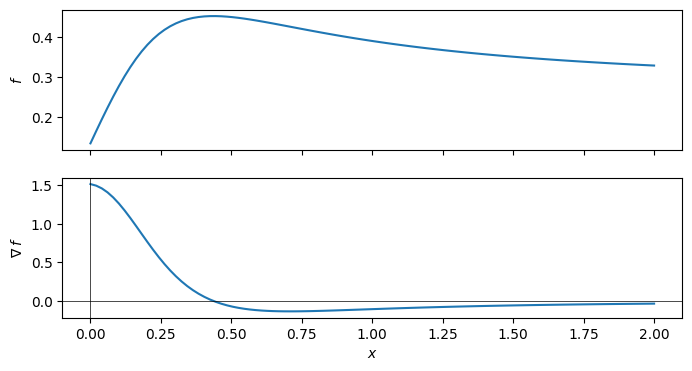

In [4]:
C = ResidualMLP(
    in_channels=1, 
    device=device
)

fine = Fine_RBM(device=device)
coarse = A1_RBM(device=device)

sampler = HMC()
sampler.potential = lambda J : 0

C.eval()
plot(C, show_root=True)

# Training

In [5]:
optimizer = torch.optim.Adam(C.parameters())

In [6]:
epochs = 2048
n_batches = 8
k = 32

In [7]:
C.train()

J = torch.tensor([1.])
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    loss = 0

    beta = 4 * (epoch / epochs)
    sampler.potential = lambda J : beta * -(grad(C, J) ** 2)

    J = sampler.step(J)
    fine.J = J
    coarse.J = J - grad(C, J)

    loss = free_energy_difference(
        fine, coarse, 
        n_batches=n_batches, k=k
    )
    loss.backward()
    optimizer.step()

100%|███████████████████████████████████████| 2048/2048 [01:18<00:00, 26.06it/s]


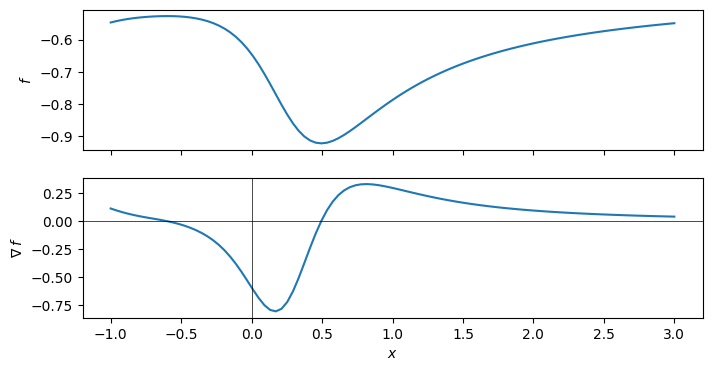

In [8]:
C.eval()
plot(C, xlim=(-1, 3))